# Install and Set up

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [2]:
# import sys
# sys.path.append('/content/gdrive/MyDrive/PrimeVisionProj')

In [3]:
# %cd /content/gdrive/MyDrive/PrimeVisionProj
# !ls

In [4]:
# !pip install rl4co==0.3.3
# !pip install torch==2.3.0
# !pip install matplotlib

# Build Model and test untrained model

In [5]:
from SPPembeddings import SPPInitEmbedding, SPPContext, StaticEmbedding
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy, POMO, POMOPolicy
from SPPenv import SPPEnv
from FPenv import FPEnv

# env = SPPEnv(num_loc=100)
env = FPEnv(fp_path="Floorplans/RL/Chicago/floorplan.json")

# from SPPv2env import SPPv2Env
# env = SPPv2Env(num_loc=100)

# Instantiate policy with the embeddings we created above
emb_dim = 64
# policy = AutoregressivePolicy(env,
#                               embedding_dim=emb_dim,
#                               init_embedding=SPPInitEmbedding(emb_dim),
#                               context_embedding=SPPContext(emb_dim),
#                               dynamic_embedding=StaticEmbedding(emb_dim)
# )

policy = POMOPolicy(env,
                    embedding_dim=emb_dim,
                    init_embedding=SPPInitEmbedding(emb_dim),
                    context_embedding=SPPContext(emb_dim),
                    dynamic_embedding=StaticEmbedding(emb_dim),
                    train_decode_type="greedy",
                    val_decode_type="greedy",
                    test_decode_type="greedy"
                    )

# model = POMO(env, policy=policy,
#                   baseline='shared',
#                   batch_size=3,
#                   train_data_size=500,
#                   val_data_size=100,)

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       policy=policy,
                       baseline='rollout',
                       train_data_size=100_00,
                       val_data_size=200_0,
                       batch_size=8,
                       val_batch_size=8,
                       test_batch_size=8
                       )

Problem 1 | Cost: 61.000
Actions Sizes: torch.Size([61])
Actions indices: tensor([148, 133,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 137, 119, 120, 121, 122, 123,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27, 135,  28,  29,
         30, 118, 113, 114, 115])
Problem 2 | Cost: 114.000
Actions Sizes: torch.Size([114])
Actions indices: tensor([ 28,  29,  30, 118, 113, 114, 115, 116, 117,  31,  33,  44,  45,  46,
         47,  58,  59,  60,  61,  62,  63,  64,  65,  66, 126, 143, 136, 144,
        131,  67,  68,  69,  70,  71,  73,  74,  75,  76,  77,  78,  79,  80,
        127, 145, 146, 132,  81,  82,  83,  84,  85,  86,  87,  88,  91,  92,
         93,  94,  95, 128, 147, 134, 148, 133,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 137, 119, 120,
        121, 122, 123,   0,   1,   2

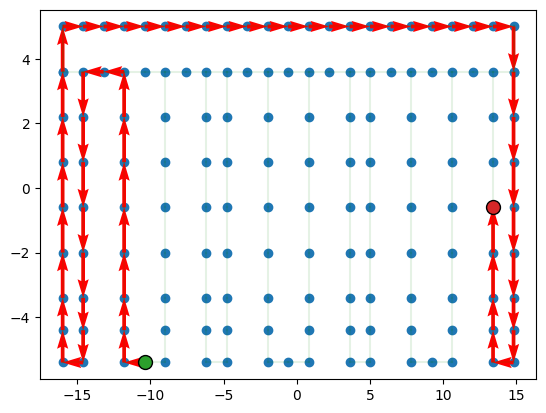

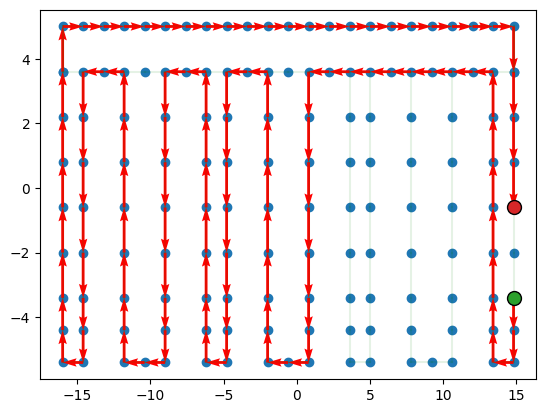

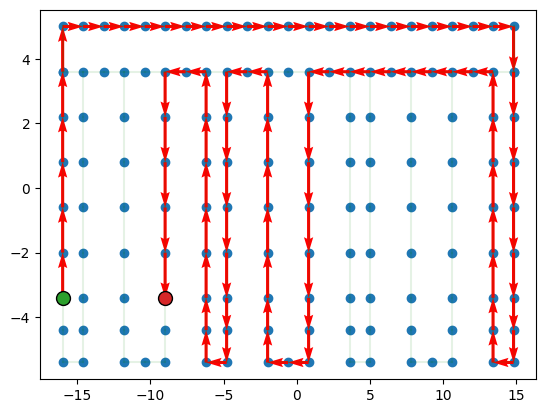

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[4]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

# Train model

In [7]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    logger=None
)

trainer.fit(model)

# Save the model
torch.save(model, 'Models/TrainOnChicagoV1.pth')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | env      | FPEnv          | 0      | train
1 | policy   | POMOPolicy     | 527 K  | train
2 | baseline | WarmupBaseline | 527 K  | train
----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.217     Total estimated model params size (MB)
102       Modules in train mode
98        Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s, v_num=40, train/reward=-45.8, train/loss=0.353, val/reward=-50.8]   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s, v_num=40, train/reward=-45.8, train/loss=0.353, val/reward=-50.8]


# Test trained model on grid map without obstacles


Actions Sizes: torch.Size([61])
Actions indices: tensor([148, 133,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 137, 119, 120, 121, 122, 123,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27, 135,  28,  29,
         30, 118, 113, 114, 115])
Actions Sizes: torch.Size([47])
Actions indices: tensor([148, 133,  96,  97,  98,  99, 100, 101, 102, 103,  90,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27, 135,  28,  29,
         30, 118, 113, 114, 115])
Actions Sizes: torch.Size([48])
Actions indices: tensor([134, 148, 133,  96,  97,  98,  99, 100, 101, 102, 103,  90,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27, 135,  28,
     

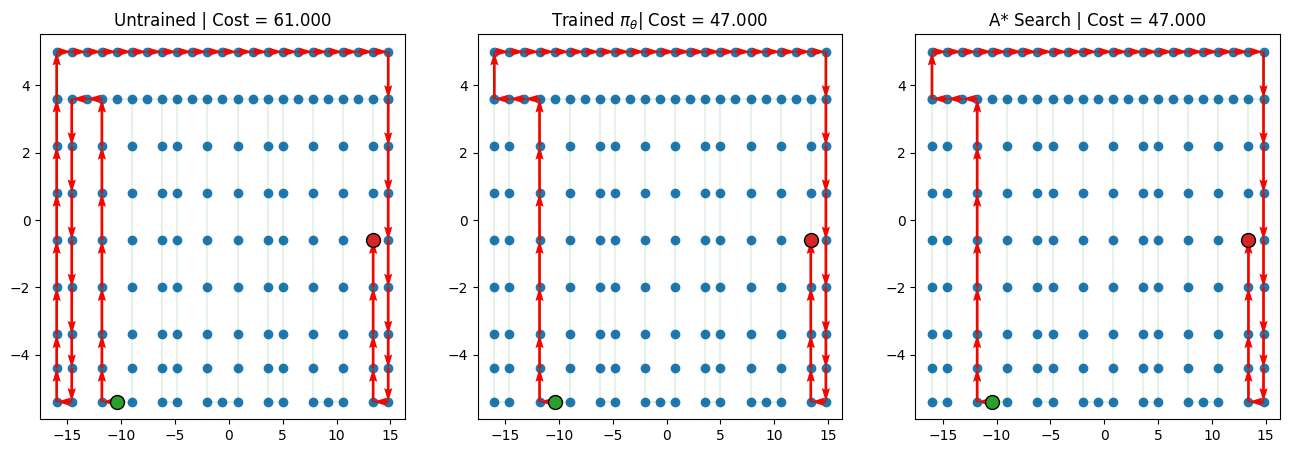

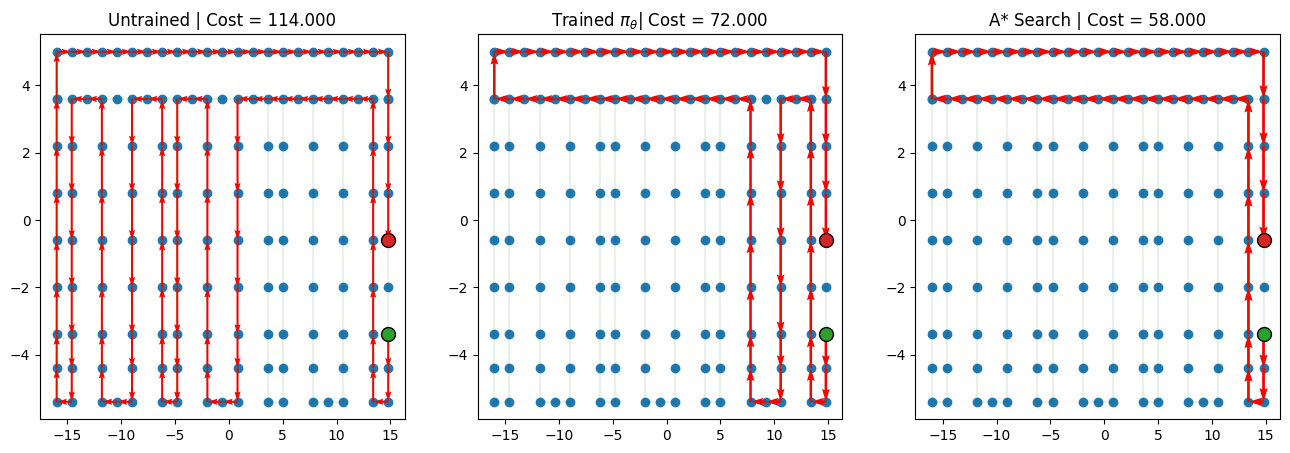

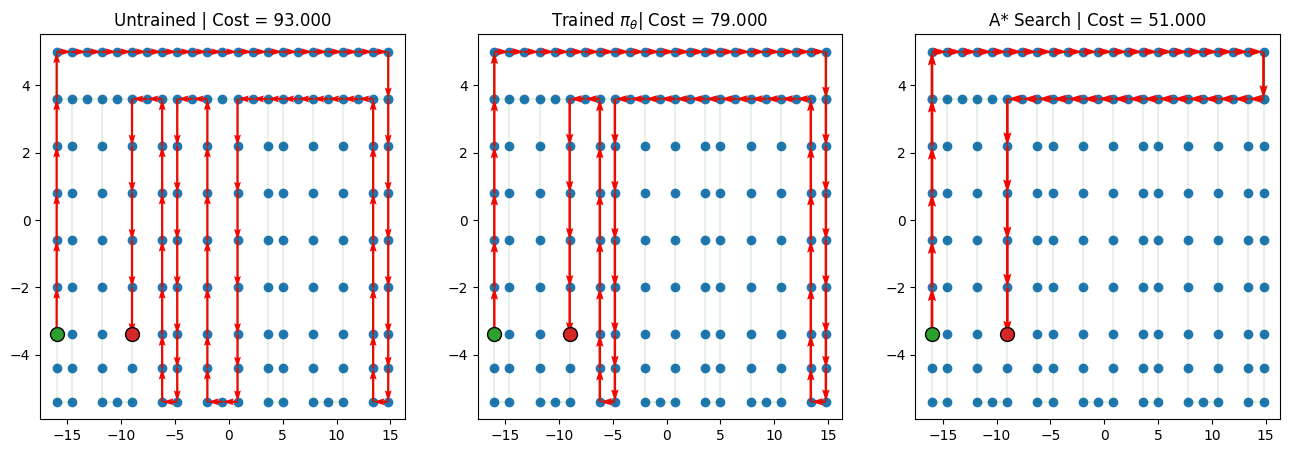

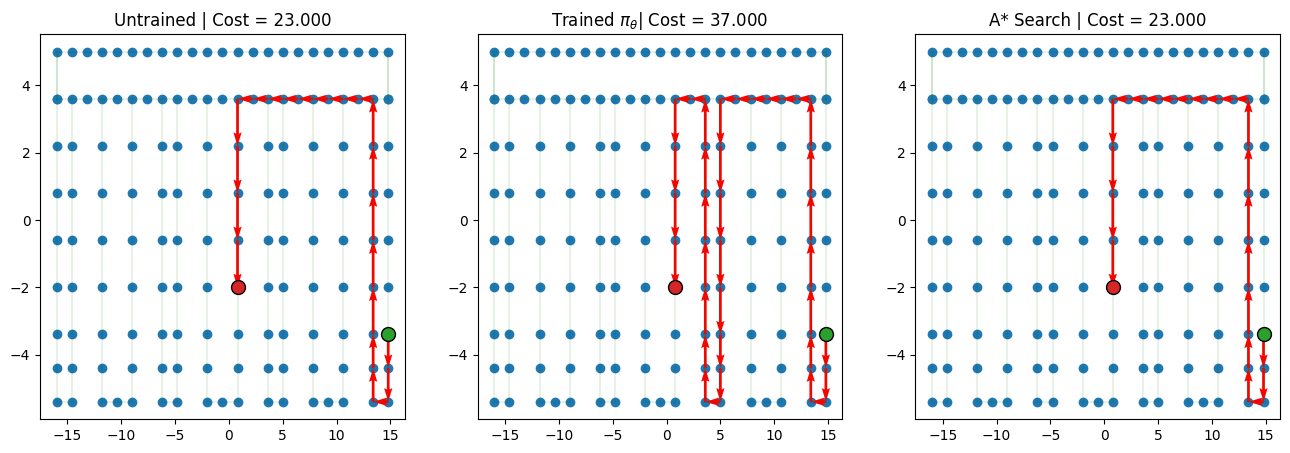

In [8]:
from astar import AStarSearch

# infer_env = SPPEnv(num_loc=500)
#from SPPenv import SPPEnv
#infer_env = SPPDynamicEnv(num_loc=100)
# infer_env = SPPEnv(num_loc=100)

# td_init = env.reset(batch_size=[3]).to(device)

# model = model.to(device)
# out = model(td_init.clone(),env=env, phase="test", decode_type="greedy",
# return_actions=True)
# actions_trained = out['actions'].cpu().detach()

policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,3, figsize=(16,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")

    env.render(td, actions_trained[i], ax=axs[1])
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    env.render(td, actions_astar[i], ax=axs[2])
    axs[2].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))

# Test trained model on grid map with obstacles

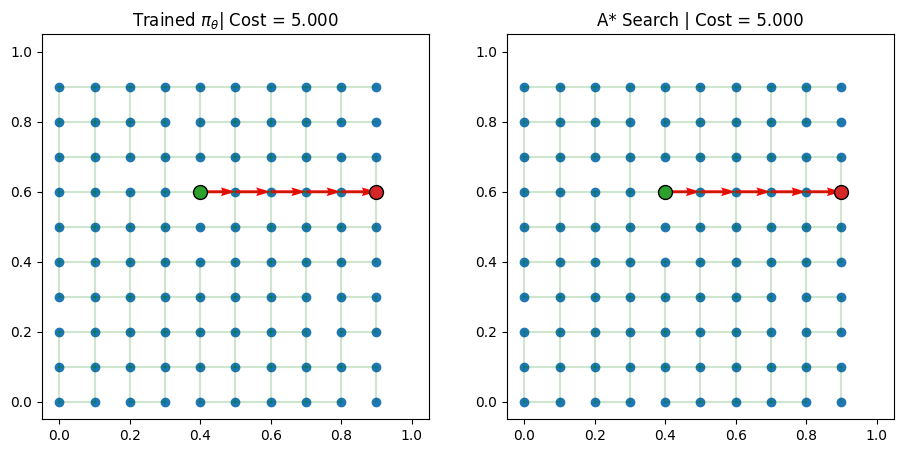

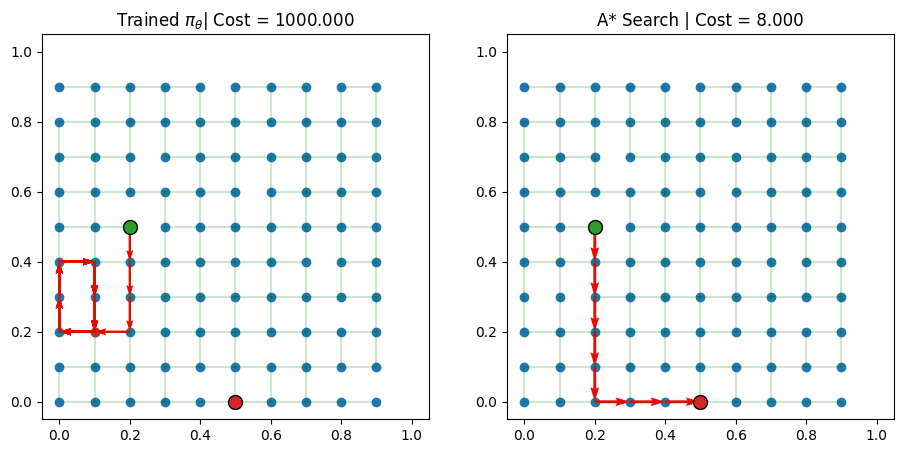

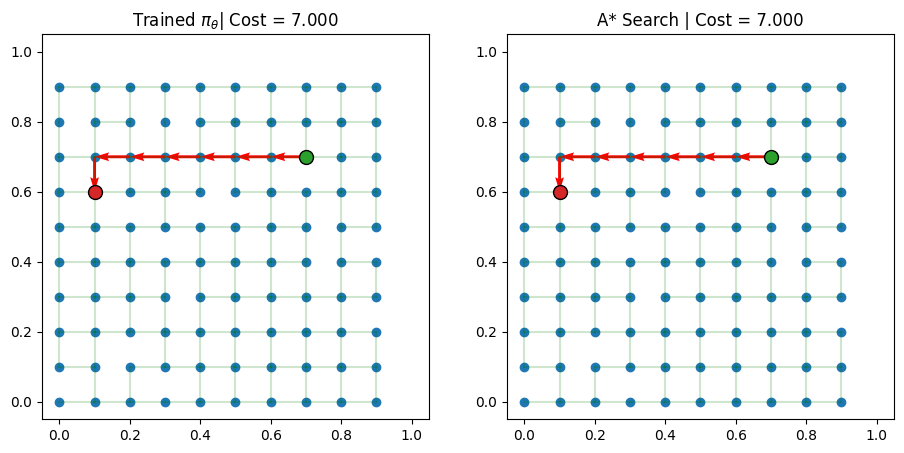

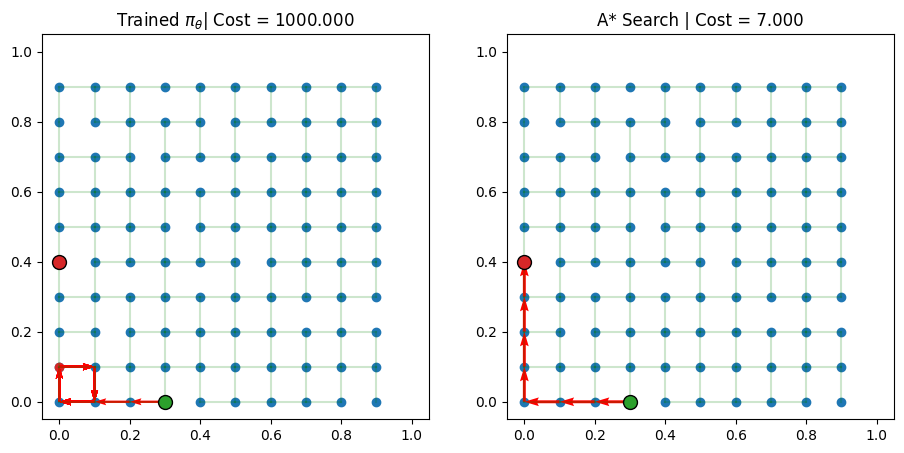

In [8]:
from SPPv2env import SPPv2Env

infer_env = SPPv2Env(num_loc=100)
td_init = infer_env.reset(batch_size=[4]).to(device)

policy = model.policy.to(device)
out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_trained[i], ax=axs[0])
    axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    infer_env.render(td, actions_astar[i], ax=axs[1])
    axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))

In [ ]:
# import numpy as np
# # Initialize the total costs
# total_cost_trained = 0
# total_cost_astar = 0
# cost_list_trained = np.array([])
# cost_list_astar = np.array([])
# 
# # Number of runs
# num_runs = 100
# 
# batch_size = 10
# 
# # Initialize the action lists
# actions_trained = []
# actions_astar = []
# 
# # Initialize the TensorDict list
# td_list = []
# 
# for _ in range(num_runs):
#     while True:
#         try:
#             # Initialize the action lists for the current run
#             actions_trained_run = []
#             actions_astar_run = []
# 
#             # infer_env = SPPEnv(num_loc=100)
#             # td_init = infer_env.reset(batch_size=[batch_size]).to(device)
# 
#             infer_env = SPPv2Env(num_loc=100)
#             td_init = infer_env.reset(batch_size=[batch_size]).to(device)
# 
#             # Run the trained DRL model
#             out = policy(td_init.clone(), infer_env, phase="test", decode_type="multistart_greedy", return_actions=True)
#             total_cost_trained += out['reward'].sum().item()
# 
#             # Run A* search
#             astar = AStarSearch(td_init.clone())
#             astar_out = astar.search()
#             total_cost_astar += astar_out["reward"].sum().item()
# 
#             # Store the TensorDict
#             td_list.append(td_init)
# 
#             # Store the output of the astar and trained model
#             actions_trained.append(out["actions"].cpu().detach())
#             actions_astar.append(astar_out["actions"].cpu().detach())
# 
#             # Store the cost of the trained model and A* search
#             cost_list_trained = np.append(cost_list_trained, out["reward"].cpu().detach().numpy())
#             cost_list_astar = np.append(cost_list_astar, astar_out["reward"].cpu().detach().numpy())
# 
#             break
#         except:
#             continue
# 
#     # Append the action lists for the current run to the overall action list
#     # actions_trained.append(actions_trained_run)
#     # actions_astar.append(actions_astar_run)
# 
# # How many -1000 rewards are there in the trained DRL model
# nosols_trained = np.sum(cost_list_trained == -1000)
# print(f"Number of unsolved problems in trained DRL model: {nosols_trained}")
# 
# # Remove all the -1000 rewards
# cost_list_trained_filtered = cost_list_trained[cost_list_trained != -1000]

In [ ]:
# # Calculate the average costs
# print ("Mean cost of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_trained_filtered.mean()))
# print ("Mean cost of A* search over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_astar.mean()))
# 
# # Calculate the mean and standard deviation of the costs
# print ("Median cost of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, np.median(cost_list_trained_filtered)))
# print ("Median cost of A* search over {} runs: {:.3f}".format(num_runs * batch_size, np.median(cost_list_astar)))
# print ("Standard deviation of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_trained_filtered.std()))
# print ("Standard deviation of A* search over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_astar.std()))
# 
# # Plot the histogram of the costs
# plt.hist(cost_list_trained_filtered, bins=20, alpha=0.7, label='Trained DRL Model')
# plt.hist(cost_list_astar, bins=20, alpha=0.7, label='A* Search')
# plt.legend(loc='upper right')
# plt.xlabel('Cost')
# plt.ylabel('Frequency')
# plt.title('Histogram of costs')
# plt.show()
# 
# # Get the indices of the runs with the highest costs
# worst_runs = np.argsort(cost_list_astar)[::-1][-3:]
# print(worst_runs)
# print(cost_list_astar[worst_runs])
# 
# # Plot the actions for the first run
# import matplotlib.pyplot as plt
# 
# for run in worst_runs:
#     quotient, remainder = divmod(run, batch_size)
#     print(quotient, remainder)
#     for i, td in enumerate(td_list[quotient]):
#         if i == remainder:
#             fig, axs = plt.subplots(1,2, figsize=(11,5))
# 
#             try:
#                 infer_env.render(td, actions_trained[quotient][i], ax=axs[0])
#                 axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {cost_list_trained[run]:.3f}")
#             except Exception as e:
#                 print(e)
#                 print("Error in plotting trained model")
#                 pass
# 
#             infer_env.render(td, actions_astar[quotient][i], ax=axs[1])
#             axs[1].set_title("A* Search | Cost = {:.3f}".format(cost_list_astar[run]))
# 
# # Plot the actions with the largest difference between the trained model and A* search
# diff = - cost_list_trained + cost_list_astar
# largest_diffs = np.argsort(diff)[::-1][:3]
# print(largest_diffs)
# 
# for run in largest_diffs:
#     quotient, remainder = divmod(run, batch_size)
#     print(quotient, remainder)
#     for i, td in enumerate(td_list[quotient]):
#         if i == remainder:
#             fig, axs = plt.subplots(1,2, figsize=(11,5))
# 
#             try:
#                 infer_env.render(td, actions_trained[quotient][i], ax=axs[0])
#                 axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {cost_list_trained[run]:.3f}")
#             except Exception as e:
#                 print(e)
#                 print("Error in plotting trained model")
#                 pass
# 
#             infer_env.render(td, actions_astar[quotient][i], ax=axs[1])
#             axs[1].set_title("A* Search | Cost = {:.3f}".format(cost_list_astar[run]))

# Real Floorplan Path Finding with Reinforcement Learning and Astar Search

## Salt Lake City Floorplan


In [ ]:
from FPenv import FPEnv
from astar import AStarSearch
import torch

# Setup a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

infer_env = FPEnv(fp_path="Floorplans/USPS/0026_Salt_Lake_City/floorplan.json")
td_init = infer_env.reset(batch_size=[4]).to(device)


# Function to check for NaNs in a tensor dictionary
nan_found = False
for key, tensor in td_init.items():
    if torch.isnan(tensor).any():
        nan_found = True
        print(f"NaN values found in tensor '{key}'")
if not nan_found:
    print("No NaN values found in the tensor dictionary.")

policy = model.policy.to(device)

out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_trained[i], ax=axs[0])
    axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    infer_env.render(td, actions_astar[i], ax=axs[1])
    axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))


RuntimeError: random_ expects 'from' to be less than 'to', but got from=0 >= to=0

## Butterfly 14 x 11 Floorplan

No NaN values found in the tensor dictionary.
reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Actions Sizes: torch.Size([1000])
Actions indices: tensor([340, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 386, 385, 384,
        352, 353, 528, 529, 560, 559, 558, 557, 556, 555, 554, 566, 567, 564,
        561, 548, 549, 550, 331, 301, 299, 298, 297, 254, 251, 247, 252, 282,
        340, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 386, 385, 384,
        352, 353, 528, 529, 560, 559, 558, 557, 556, 555, 554, 566, 567, 564,
        561, 548, 549, 550, 331, 301, 299, 298, 297, 254, 251, 247, 252, 282,
        340, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 386, 385, 384,
        352, 353, 528, 529, 560, 559, 558, 557, 556, 555, 554, 566, 567, 564,
        561, 548, 549, 550, 331, 301, 299, 298, 297, 254, 251, 247, 252, 282,
        340, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 386, 385, 384,
        352, 353, 528, 529, 560, 559, 558, 557, 556, 555

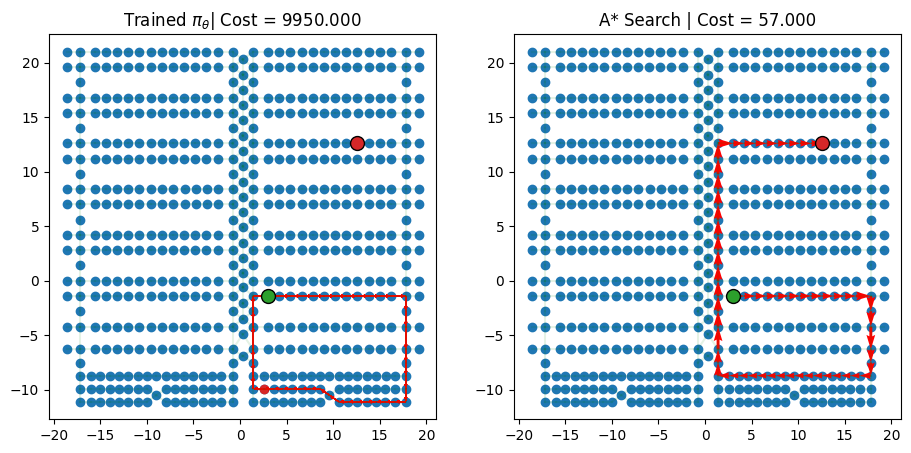

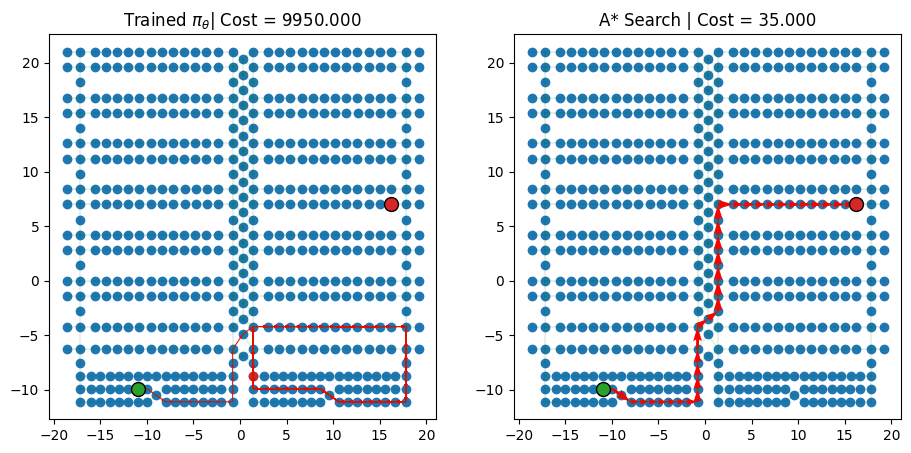

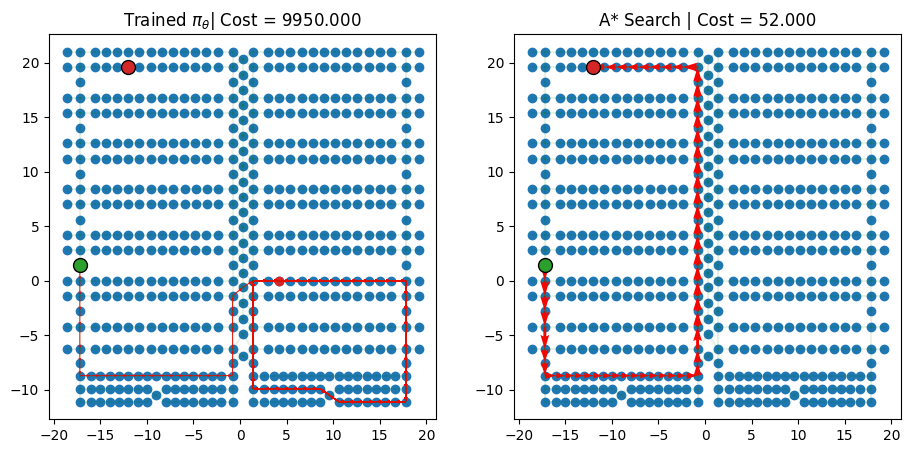

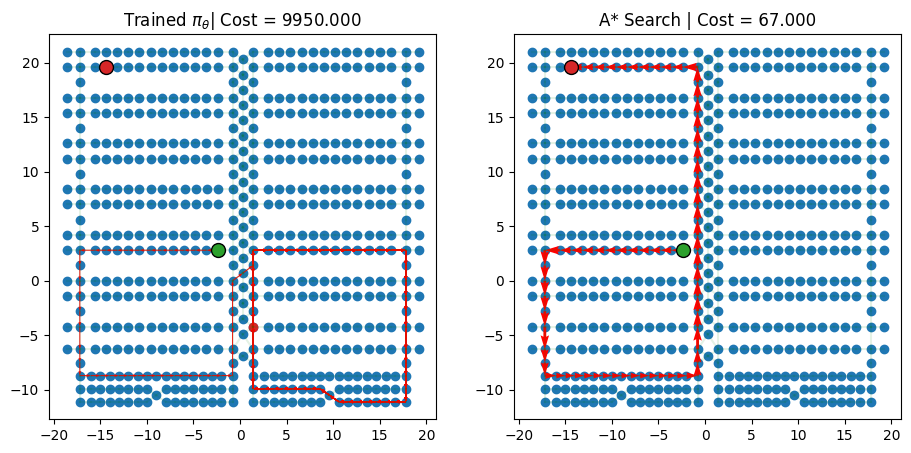

In [ ]:
from FPenv import FPEnv
from astar import AStarSearch
import torch

# Setup a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

infer_env = FPEnv(fp_path="Floorplans/quad-infeed/butterfly/14x11/floorplan.json")
td_init = infer_env.reset(batch_size=[4]).to(device)


# Function to check for NaNs in a tensor dictionary
nan_found = False
for key, tensor in td_init.items():
    if torch.isnan(tensor).any():
        nan_found = True
        print(f"NaN values found in tensor '{key}'")
if not nan_found:
    print("No NaN values found in the tensor dictionary.")

policy = model.policy.to(device)

out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_trained[i], ax=axs[0])
    axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    infer_env.render(td, actions_astar[i], ax=axs[1])
    axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))


## All Floorplans

In [ ]:
from FPenv import FPEnv
from astar import AStarSearch
from Floorplan_Codes.utils import get_paths
import torch

# Setup a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

floorplans = get_paths("floorplan.json", "Floorplans/USPS", recursive=True, depth=1)
ids = []
for floorplan in floorplans:
    try:
        infer_env = FPEnv(fp_path=floorplan)
        td_init = infer_env.reset(batch_size=[4]).to(device)


        # Function to check for NaNs in a tensor dictionary
        nan_found = False
        for key, tensor in td_init.items():
            if torch.isnan(tensor).any():
              nan_found = True
              print(f"NaN values found in tensor '{key}'")
        if not nan_found:
            print("No NaN values found in the tensor dictionary.")

        policy = model.policy.to(device)

        out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
        actions_trained = out['actions'].cpu().detach()

        # run A* search on the environment
        astar = AStarSearch(td_init.clone())
        astar_out = astar.search()
        actions_astar = astar_out["actions"].cpu().detach()

        # Plotting
        import matplotlib.pyplot as plt
        for i, td in enumerate(td_init):
            fig, axs = plt.subplots(1,2, figsize=(11,5))

            parts = floorplan.split('/')
            site = parts[-2]
            fig.suptitle("Floorplan: " + site, fontsize=16)

            infer_env.render(td, actions_trained[i], ax=axs[0])
            axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

            infer_env.render(td, actions_astar[i], ax=axs[1])
            axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))
    except Exception as e:
        print(e)
        continue


Output hidden; open in https://colab.research.google.com to view.